In [ ]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency t
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import pickle

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well

#plot
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp #for easy barplot

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, ts_visual, correct_key
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
rv = 0

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define parameters

In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_binmn = config.li_binmn
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
path_extracted_data_visual_adap_clustering = os.path.join(path_extracted_data_visual_adap,'clustering')
for nbr_bin in li_binmn:
    path_extracted_data_visual_adap_binmn = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability',str(nbr_bin))
    #create a director if not existing
    if not os.path.exists(path_extracted_data_visual_adap_binmn):
        os.makedirs(path_extracted_data_visual_adap_binmn)

change the configuration file if not done yet!


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [5]:
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_visual_adap, 'li_selected_hens.pkl'), 'rb'))
print(len(li_selected_hens))
#for now we have only distance restricted to 70 animals
#compute the CHI2DISTANCE & DTW for each bird with all other birds (because we need this exact same pair to do the visual)
#rv = 0
#random.seed(rv)
#nbr_hens = 70
#randomly pick more than one element from the list without repeating elements.
#li_selected_hens = random.sample(li_selected_hens, nbr_hens)
print('possible animal pairs: ',len(li_selected_hens)*(len(li_selected_hens)-1)/2)

131
possible animal pairs:  8515.0


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
#distance measure (chi2, dtw)
#old: correctlightschedule_0_df_interintra_SAMEDAY_ALL
df_inter = pd.read_csv(os.path.join(path_extracted_data_visual_adap, id_run+'_df_DistanceBetweenHenSim.csv'), sep=';', 
                      parse_dates=['level1','level2'], dayfirst=True)
#weeks of age starting on the first day where the bird was here during 24h
df_inter['weeks_in_laying_barn'] = df_inter['DOA'].map(lambda x: int((x-119)/7)+1)
df_inter['DIB'] = df_inter['DOA'].map(lambda x: x-118)
display(df_inter[['level1','DOA','weeks_in_laying_barn']].drop_duplicates().reset_index().head(3))
#remove weeks_in_laying_barn to avoid confusions
df_inter.drop(['WOA'],inplace=True,axis=1)
#select only inter 
df_inter['animal_pair']  = df_inter.apply(lambda x: '-'.join(sorted([x['henID1'],x['henID2']])), axis=1)
print(df_inter.shape)
df_inter.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,level1,DOA,weeks_in_laying_barn
0,0,2020-09-30,119,1
1,8515,2020-10-01,120,1
2,17030,2020-10-02,121,1


(212264, 98)


,level1,level2,henID1,henID2,dur_values_normalized_henID1,dur_values_normalized_henID2,chi2distance,DOA,nbr_obs_chi2all_5,chi2distance_ALL_5,...,nbr_obs_l1_30_4_Zone,nbr_obs_l2_30_4_Zone,DTW_30_1_Zone,nbr_obs_l1_30_1_Zone,nbr_obs_l2_30_1_Zone,weeks_in_laying_barn,hen_pair,DTW_15_all,DIB,animal_pair
0,2020-09-30,2020-09-30,hen_1,hen_10,"[0.0, 0.6557638888888889, 0.12111111111111111,...","[0.0, 0.40243055555555557, 0.5327083333333333,...",0.233889,119,288,250.143992,...,48,48,0.0,48,48,1,hen_1-hen_10,315.1,1,hen_1-hen_10
1,2020-09-30,2020-09-30,hen_2,hen_47,"[0.0, 0.3379861111111111, 0.23836805555555557,...","[0.0, 0.8774305555555556, 0.11180555555555556,...",0.341557,119,288,73.192771,...,48,48,0.0,48,48,1,hen_2-hen_47,166.6,1,hen_2-hen_47
2,2020-09-30,2020-09-30,hen_2,hen_46,"[0.0, 0.3379861111111111, 0.23836805555555557,...","[0.0, 0.2679861111111111, 0.059409722222222225...",0.110694,119,288,243.112474,...,48,48,0.0,48,48,1,hen_2-hen_46,341.3,1,hen_2-hen_46


In [7]:
#daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True) 
df_daily['DOA'] = df_daily['level'].map(lambda x: (x-birth_date).days) 
df_daily['WOA'] = df_daily['DOA'].map(lambda x: math.ceil(x/7))
#first two month seems good from the %of hens not moving plot! and sounds good too (twice longer thatn they need to start moving)
print(df_daily.shape)
df_daily = df_daily[(df_daily['level']>dt.datetime(2020,9,29))&(df_daily['level']<=max_date_adaptability)] 
#df_daily.groupby(['PenID'])['Treatment'].agg(lambda x: set(x)).reset_index()
print(df_daily.shape)
display(df_daily[['level','DOA','WOA']].tail(3))
print(df_daily.shape)

#remove days that are not fully recorded
df_daily['nbr_sec_per_day'] = df_daily['level'].map(lambda x: dico_night_hour[correct_key(x,dico_night_hour)]['nbr_hour']*60*60)
df_daily['is_correct_amount_time'] = df_daily.apply(lambda x: x['nbr_sec_per_day']==x['verification_daily_total_duration'], axis=1)
df_daily[(~df_daily['is_correct_amount_time'])&(~df_daily['Total_number_transition'].isnull())][['level', 'HenID', 'Total_number_transition', 'dur_values', 'verification_daily_total_duration','nbr_sec_per_day']]
print(df_daily.shape)
display(df_daily = df_daily[~((~df_daily['is_correct_amount_time'])&(~df_daily['Total_number_transition'].isnull()))])
print(df_daily.shape)

#remove the days where the night had movement recorded but not the days
print(df_daily.shape)
df_daily = df_daily[['HenID','PenID','level','Treatment', 'CLASS', 'DOA','WOA','dur_values','dur_values_normalized','perc_duration_1_Zone', 'perc_duration_2_Zone',
          'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone','Total_number_transition']]
#display(df_daily[df_daily.isna().any(axis=1)])
df_daily = df_daily[~df_daily.isna().any(axis=1)]
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(27214, 198)
(8679, 198)


,level,DOA,WOA
27117,2020-11-20,170,25
27118,2020-11-21,171,25
27119,2020-11-22,172,25


(8679, 198)
(8679, 198)
(8679, 198)
(8679, 198)
(7619, 15)


,HenID,PenID,level,Treatment,CLASS,DOA,WOA,dur_values,dur_values_normalized,perc_duration_1_Zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,Total_number_transition
0,hen_1,9,2020-09-30,OFH,EPI,119,17,"[0.0, 18886.0, 3488.0, 518.0, 5908.0]","[0.0, 0.6557638888888889, 0.12111111111111111,...",0.0,65.576389,12.111111,1.798611,20.513889,6.0
1,hen_1,9,2020-10-01,OFH,EPI,120,18,"[0.0, 9310.0, 5636.0, 0.0, 17454.0]","[0.0, 0.2873456790123457, 0.17395061728395061,...",0.0,28.734568,17.395062,0.000000,53.870370,12.0
2,hen_1,9,2020-10-02,OFH,EPI,121,18,"[0.0, 0.0, 551.0, 0.0, 31849.0]","[0.0, 0.0, 0.017006172839506173, 0.0, 0.982993...",0.0,0.000000,1.700617,0.000000,98.299383,2.0


In [39]:
#focal birds info (one row per bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data,id_run+'df_FOCALBIRDS.csv'), sep=';', parse_dates=['InitialStartDate'],
                     dayfirst=True) 
df_FB = df_FB[df_FB['HenID'].isin(li_selected_hens)]
df_FB['percentage_of_gain_weight'] = df_FB.apply(lambda x: (x['weight 23-11-2020']-x['29-09 weight'])/x['29-09 weight']*100, axis=1)
print(df_FB.shape)
df_FB.head(3)

(130, 12)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,Treatment,percentage_of_gain_weight
0,hen_1,9,EPI,1.0,2020-06-10,1134.0,57.0,1696.5,1787.8,1800.9,OFH,49.603175
1,hen_10,11,LEXP,1.0,2020-06-10,1070.0,70.4,1488.3,1628.4,1602.1,OFH,39.093458
3,hen_101,5,MEXP,3.0,2020-06-10,1082.0,66.0,1625.7,1751.1,1723.4,OFH,50.249538


# Clustering on Chi2distance 15mn sum overall period

#FOR NOW; THEN REMOVE IT!!!
#df_inter = df_inter[df_inter['PenID']=='pen11']
#TO CHANGE!!!
len(df_inter['henID1'].unique())
li_selected_hens = list(df_inter['henID1'].unique())

In [8]:
#TODO: what about animals having missing days? morelikley to be cluster together??? chekc them and remove them if necessary

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
#hen143 is always cluster alone: re,ove it for now, then try to find outliers
#df_inter[(df_inter['henID1']=='hen_143')|(df_inter['henID2']=='hen_143')][['level1','henID1','henID2',V]]
print(df_inter.shape)
df_inter = df_inter[~((df_inter['henID1']=='hen_143')|(df_inter['henID2']=='hen_143'))]
li_selected_hens = [i for i in li_selected_hens if i!='hen_143']
print(df_inter.shape)
df_inter.head(2)

(208886, 98)
(208886, 98)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level1,level2,henID1,henID2,dur_values_normalized_henID1,dur_values_normalized_henID2,chi2distance,DOA,nbr_obs_chi2all_5,chi2distance_ALL_5,...,nbr_obs_l1_30_4_Zone,nbr_obs_l2_30_4_Zone,DTW_30_1_Zone,nbr_obs_l1_30_1_Zone,nbr_obs_l2_30_1_Zone,weeks_in_laying_barn,hen_pair,DTW_15_all,DIB,animal_pair
0,2020-09-30,2020-09-30,hen_1,hen_10,"[0.0, 0.6557638888888889, 0.12111111111111111,...","[0.0, 0.40243055555555557, 0.5327083333333333,...",0.233889,119,288,250.143992,...,48,48,0.0,48,48,1,hen_1-hen_10,315.1,1,hen_1-hen_10
1,2020-09-30,2020-09-30,hen_2,hen_47,"[0.0, 0.3379861111111111, 0.23836805555555557,...","[0.0, 0.8774305555555556, 0.11180555555555556,...",0.341557,119,288,73.192771,...,48,48,0.0,48,48,1,hen_2-hen_47,166.6,1,hen_2-hen_47


In [162]:
print(df_inter.columns)

Index(['level1', 'level2', 'henID1', 'henID2', 'dur_values_normalized_henID1',
       'dur_values_normalized_henID2', 'chi2distance', 'DOA',
       'nbr_obs_chi2all_5', 'chi2distance_ALL_5', 'DTW_5_3_Zone',
       'nbr_obs_l1_5_3_Zone', 'nbr_obs_l2_5_3_Zone', 'DTW_5_2_Zone',
       'nbr_obs_l1_5_2_Zone', 'nbr_obs_l2_5_2_Zone', 'DTW_5_5_Zone',
       'nbr_obs_l1_5_5_Zone', 'nbr_obs_l2_5_5_Zone', 'DTW_5_4_Zone',
       'nbr_obs_l1_5_4_Zone', 'nbr_obs_l2_5_4_Zone', 'DTW_5_1_Zone',
       'nbr_obs_l1_5_1_Zone', 'nbr_obs_l2_5_1_Zone', 'nbr_obs_chi2all_10',
       'chi2distance_ALL_10', 'DTW_10_3_Zone', 'nbr_obs_l1_10_3_Zone',
       'nbr_obs_l2_10_3_Zone', 'DTW_10_2_Zone', 'nbr_obs_l1_10_2_Zone',
       'nbr_obs_l2_10_2_Zone', 'DTW_10_5_Zone', 'nbr_obs_l1_10_5_Zone',
       'nbr_obs_l2_10_5_Zone', 'DTW_10_4_Zone', 'nbr_obs_l1_10_4_Zone',
       'nbr_obs_l2_10_4_Zone', 'DTW_10_1_Zone', 'nbr_obs_l1_10_1_Zone',
       'nbr_obs_l2_10_1_Zone', 'nbr_obs_chi2all_15', 'chi2distance_ALL_15',
       

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [206]:
########################### define parameters ###########################
#chose nbr of day involve in the clustering
#fixing the number of days, emans that we actually cluster different things and the difference between clustering can be due 
#to the last days and/or the first days
#nbr_days_involved = 30
#type_ = 'nbrdaysfix' #nbrdaysfix, enddayfixed

type_ = 'enddayfixed'
#chose starting DIB possiilityy
li_starting_DIB = list(range(1,30))
#rs = 0
#choose number of cluster
li_nbr_cluster = [2,3,4,5,6,7,8,9,10]
#choose distance measure
V = 'chi2distance_ALL_15'
V = 'DTW_15_all'
V = 'chi2distance_ALL_30'
V = 'DTW_15_3_Zone'

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#create folder for saving
path_extracted_data_visual_adap_clustering_V = os.path.join(path_extracted_data_visual_adap_clustering, V)
if not os.path.exists(path_extracted_data_visual_adap_clustering_V):
    os.makedirs(path_extracted_data_visual_adap_clustering_V)
    
li_df = []
df_res = pd.DataFrame({'HenID':li_selected_hens})
for nbr_cluster in tqdm.tqdm(li_nbr_cluster):
    for d1 in li_starting_DIB:
        
        #select time period
        if type_=='nbrdaysfix':
            df_ = df_inter[(df_inter['DIB']>=d1)&(df_inter['DIB']<=d1+nbr_days_involved)].copy()
        elif type_=='enddayfixed':
            df_ = df_inter[df_inter['DIB']>=d1].copy()
            l = df_['DIB'].unique()
            nbr_days_involved = max(l)-min(l)+1
        else:
            print('ERROR: You have to chose between nbrdaysfix and enddayfixed')
            sys.exit()
            
        #clustering_name
        name_clustering = type_+'_startingDIB-'+str(d1)+'_'+'nbrcluster-'+str(nbr_cluster)+'_'+'nbrdaysinvolved-'+str(nbr_days_involved)

        #aggreagte distance measure to have one distance per pair of animals
        df_clustering = df_.groupby('animal_pair')[V].agg(lambda x: np.nanmean(x)).reset_index()   
        #display(df_clustering.head(3))
        #df_clustering.to_csv(os.path.join(path_extracted_data_visual_adap_clustering_V ,name_clustering+'_meanChi2distance_15mn.csv'), 
        #                 sep=';', index=False)
        #plt.hist(df_clustering[V]);
        #plt.show();

        #compute dissimilarity matrix
        M = np.zeros(shape=(len(li_selected_hens), len(li_selected_hens))) 
        for i,h1 in enumerate(li_selected_hens):
            for h2 in li_selected_hens[i+1:]:
                #put in correct order if needed
                p = '-'.join(sorted([h1,h2]))
                #try:
                dist_ = df_clustering[df_clustering['animal_pair']==p][V].values[0]
                #except Exception as e:
                #    print(e, p)
                #    dist_ = np.nan
                M[li_selected_hens.index(h1)][li_selected_hens.index(h2)] = dist_
                M[li_selected_hens.index(h2)][li_selected_hens.index(h1)] = dist_
        #sns.heatmap(M)
        #plt.show()

        #cluster based on the dissimilarity matrix
        #If “precomputed”, a distance matrix (instead of a similarity matrix) is needed as input for the fit method.
        #TODO: CHECK
        #The agglomerative clustering is the most common type of hierarchical clustering
        cluster = AgglomerativeClustering(n_clusters=nbr_cluster, affinity='precomputed', linkage = 'average') #, linkage='ward')
        cluster.fit_predict(M)
        #print(cluster.labels_)
        df_res_ = pd.DataFrame({'HenID':li_selected_hens, name_clustering:cluster.labels_})
        #display(df_res_['clusterID'].value_counts())
        #display(df_res.head(3))
        #df_res.to_csv(os.path.join(path_extracted_data_visual_adap_clustering_V ,name_clustering+'_results.csv'), 
        #                 sep=';', index=False)     
        df_res = pd.merge(df_res, df_res_, on='HenID')        
        li_df.append({'clusteringID':name_clustering, 'nbr_cluster':nbr_cluster, 'nbr_days_involved':nbr_days_involved, 
                      'li_starting_DIB':d1})
print(df_res.shape)
display(df_res.head(3)) 
    
#save meta data info of clusterings
df_clusteringMetadata = pd.DataFrame(li_df)
print(df_clusteringMetadata.shape)
df_clusteringMetadata.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

#merge with all daily info: at (day, hen) level
df_analyse_hd = pd.merge(df_daily, df_res, on=['HenID'], how='left')
print(df_analyse_hd.shape, df_daily.shape)
#df_analyse_hd.to_csv(os.path.join(path_cluster, id_run+'df_analyse_hd.csv'), sep=';', index=False)
df_analyse_hd.head(3)

# ARI between clusterings

In [ ]:
#for each existing possible number of clusters, compute the ARI score between each two clusterings with such nbr of clustering
li_df = []
for nbr_cluster, df_ in df_clusteringMetadata.groupby('nbr_cluster'):
    #symetric measure, compute the scoer once per pair
    li_clname = df_['clusteringID'].unique()
    for i,cl_type1 in enumerate(li_clname):
        for cl_type2 in li_clname[i+1:]:
            ARI = adjusted_rand_score(df_res[cl_type1].tolist(), df_res[cl_type2].tolist())
            li_df.append({'clusteringID1':cl_type1, 'clusteringID2':cl_type2, 'ARI':ARI, 'nbr_cluster':nbr_cluster,
                          'startingDIB1':int(cl_type1.split('startingDIB-')[1].split('_')[0]),
                          'startingDIB2':int(cl_type2.split('startingDIB-')[1].split('_')[0])})
#save ARI scores info
df_ari = pd.DataFrame(li_df)
df_ari['pair']  = df_ari.apply(lambda x: '-'.join(sorted([str(x['startingDIB1']),str(x['startingDIB2'])])), axis=1)
print(df_ari.shape)
df_ari.head(3)

In [ ]:
#heatmap
for nbr_cluster in li_nbr_cluster:
    #fig, ax = plt.subplots(figsize=(4,3))
    M = np.zeros(shape=(len(li_starting_DIB), len(li_starting_DIB))) 
    for i,dib1 in enumerate(li_starting_DIB):
        for dib2 in li_starting_DIB[i+1:]:
            #put in correct order if needed
            v = df_ari[(df_ari['pair']=='-'.join(sorted([str(dib1),str(dib2)])))&\
                       (df_ari['nbr_cluster']==nbr_cluster)]['ARI'].values[0]
            M[li_starting_DIB.index(dib1)][li_starting_DIB.index(dib2)] = v
            M[li_starting_DIB.index(dib2)][li_starting_DIB.index(dib1)] = v
            M[li_starting_DIB.index(dib1)][li_starting_DIB.index(dib1)] = 1 #clusterings are identical (up to a permutation).
    sns.heatmap(M)
    plt.title('number of clusters: '+str(nbr_cluster))
    plt.xlabel('first DIB considered')
    plt.ylabel('first DIB considered')
    #TODO: change x axis if figure used in article!!!!!!
    #ax.set_xticklabels([str(i) for i in dib1])
    #ax.set_yticklabels([str(i) for i in dib1])
    plt.savefig(os.path.join(path_extracted_data_visual_adap_clustering_V, 
                             'ARI_clusterings_with_nbrcluster'+str(nbr_cluster)+'.png'), dpi=200)
    plt.show()

# Visuals

In [ ]:
#lets define it as the animal with the samllest squared average distance to all others from the same cluster
#chose which clustering results oyu want to visualise 
#[i for i in df_ari['clusteringID1'].tolist() if i.startswith('enddayfixed_startingDIB-1_nbrcluster-5_')]
name_clustering = 'enddayfixed_startingDIB-1_nbrcluster-3_nbrdaysinvolved-31'
df_res[name_clustering].value_counts()
#df_res[df_res[name_clustering]==4]

In [ ]:
sys.exit()

### clustering score depending on the starting DIB day

In [193]:
#TODO once we have such a score. then compute the score for random chi2distance sumed

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### mvt features value across cluster of a particular clustering

In [194]:
#add hen info
#df_daily
df_info = pd.merge(df_res[[name_clustering,'HenID']], df_FB, on='HenID', how='left')
df_info.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,enddayfixed_startingDIB-1_nbrcluster-3_nbrdaysinvolved-31,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,Treatment,percentage_of_gain_weight
0,0,hen_1,9,EPI,1.0,2020-06-10,1134.0,57.0,1696.5,1787.8,1800.9,OFH,49.603175
1,0,hen_10,11,LEXP,1.0,2020-06-10,1070.0,70.4,1488.3,1628.4,1602.1,OFH,39.093458
2,2,hen_101,5,MEXP,3.0,2020-06-10,1082.0,66.0,1625.7,1751.1,1723.4,OFH,50.249538


In [195]:
df_res[name_clustering].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    89
2    39
1     2
Name: enddayfixed_startingDIB-1_nbrcluster-3_nbrdaysinvolved-31, dtype: int64

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


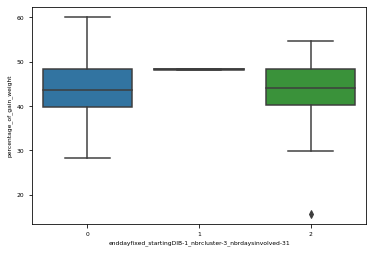

In [196]:
sns.boxplot(x=name_clustering, y="percentage_of_gain_weight",data=df_info); #palette="Set3"

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


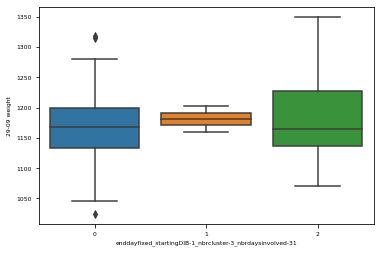

In [197]:
sns.boxplot(x=name_clustering, y="29-09 weight",data=df_info);

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


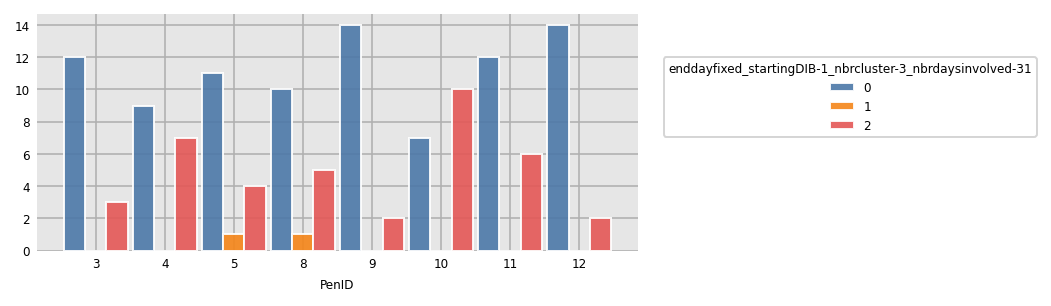

In [198]:
dxp.count('PenID', data=df_info, split=name_clustering)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


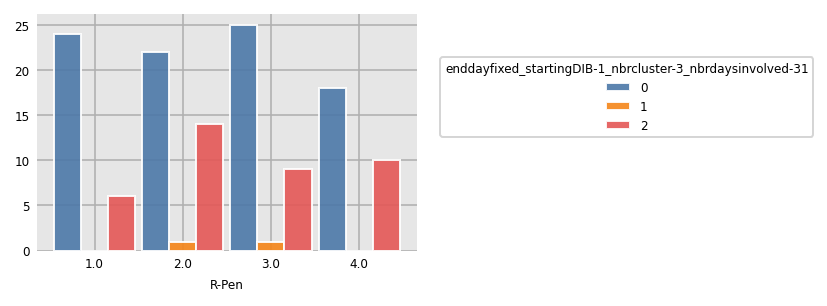

In [199]:
dxp.count('R-Pen', data=df_info, split=name_clustering) 

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


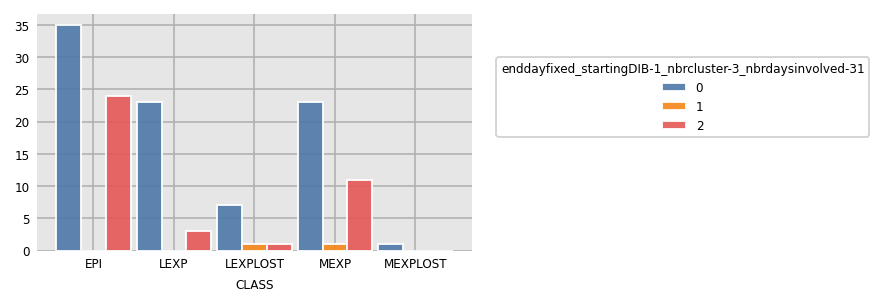

In [200]:
dxp.count('CLASS', data=df_info, split=name_clustering) 

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


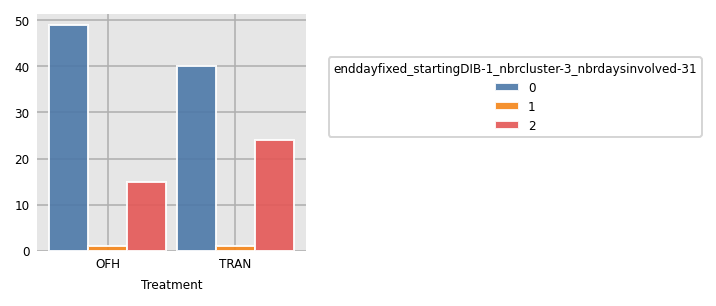

In [201]:
dxp.count('Treatment', data=df_info, split=name_clustering)

#we dont normlaize it by pen or anything as we still wan tt se the true nbr of animals per pen/treatment/class
fig = dxp.count('PenID', data=df_info, split=name_clustering)
#fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerPen.png'))
fig = dxp.count('R-Pen', data=df_info, split=name_clustering) 
#fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerRPen.png'))
fig = dxp.count('CLASS', data=df_info, split=name_clustering) 
#fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerClass.png'))
fig = dxp.count('Treatment', data=df_info, split=name_clustering) 
#fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerTreatment.png'))

### plot most representative hen within each cluster

In [202]:
dico_hen_clID = dict(zip(df_res['HenID'].tolist(), df_res[name_clustering].tolist()))
df_mr = df_inter.copy()
df_mr['henID1_cl'] = df_mr['henID1'].map(lambda x: dico_hen_clID[x])
df_mr['henID2_cl'] = df_mr['henID2'].map(lambda x: dico_hen_clID[x])
print(df_mr.shape)
df_mr = df_mr[df_mr['henID1_cl']==df_mr['henID2_cl']]
print(df_mr.shape)

df_mrh1 = df_mr.groupby(['henID1'])[V].agg(lambda x: sum(x)/len(x)).reset_index()
df_mrh1.rename(columns={'henID1':'HenID'},inplace=True)
df_mrh2 = df_mr.groupby(['henID2'])[V].agg(lambda x: sum(x)/len(x)).reset_index()
df_mrh2.rename(columns={'henID2':'HenID'},inplace=True)

df_mr_all = pd.merge(df_mrh1, df_mrh2, on='HenID', how='outer')
df_mr_all['distance'] = df_mr_all.apply(lambda x: np.nansum([x[V+'_x'], x[V+'_y']]), axis=1)
df_mr_all['clID'] = df_mr_all['HenID'].map(lambda x: dico_hen_clID[x])
df_mr_all = df_mr_all.sort_values(['distance']).groupby(['clID'])[['HenID','distance']].agg(lambda x: list(x))
display(df_mr_all)
nbr_hens = 10
li_mshens = df_mr_all['HenID'].tolist()
li_mshens = [i[0:nbr_hens] for i in li_mshens]
li_mshens = [j for i in li_mshens for j in i]
len(li_mshens)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(208886, 100)
(115887, 100)


,HenID,distance
clID,,
0,"[hen_97, hen_1, hen_102, hen_134, hen_13, hen_...","[34.45897678825204, 36.30146520146521, 55.8355..."
1,"[hen_69, hen_107]","[50.178260869565214, 50.178260869565214]"
2,"[hen_99, hen_101, hen_138, hen_40, hen_29, hen...","[41.31118951612908, 45.94203056768557, 75.5462..."


22

In [203]:
#initializse automatically set of needed paramters for the functions
#nbr_cluster_ = int(name_clustering.split('nbrcluster-')[1].split('_')[0])
nbr_days_involved_ = int(name_clustering.split('nbrdaysinvolved-')[1].split('_')[0])
li_starting_DIB_ = int(name_clustering.split('startingDIB-')[1].split('_')[0])
dmin = dt.datetime(2020,9,30)+dt.timedelta(days=li_starting_DIB_)
dmax = dt.datetime(2020,9,30)+dt.timedelta(days=li_starting_DIB_+nbr_days_involved_)
print(dmin, dmax)
dico_h_cl = dict(zip(df_res['HenID'].tolist(), df_res[name_clustering].tolist()))

#create one folder per cluster
#nbr_cluster_ = len(df_res[name_clustering].unique())
path_cluster_visual = os.path.join(path_extracted_data_visual_adap_clustering_V, name_clustering)
if not os.path.exists(path_cluster_visual):
    os.makedirs(path_cluster_visual)

2020-10-01 00:00:00 2020-11-01 00:00:00


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [204]:
#open cleaned mvt data
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp','date'],
                 dayfirst=True) 
df = df[df['HenID'].isin(li_selected_hens)]
df = df[df['HenID'].isin(li_mshens)]
print(df.shape)
df.head(3)
#small verification with the initial raw data, this cleaned data and the visual
#df[df['HenID']=='hen_1'].head(30)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(155552, 16)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,duration,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open
3,hen_49,pen10,10 - 12,2_Zone,1.0,2020-09-29 09:20:21,2020-09-29,2020-09-29 12:45:14.000,0 days 03:24:53,NaN,NaN,3_Zone,NaN,NaN,False,False
14,hen_70,pen10,10 - 12,3_Zone,1.0,2020-09-29 09:29:50,2020-09-29,2020-09-29 09:30:14.000,0 days 00:00:24,NaN,NaN,3_Zone,NaN,NaN,False,False
18,hen_94,pen3,3 - 5,2_Zone,1.0,2020-09-29 09:32:47,2020-09-29,2020-09-29 09:33:47.000,0 days 00:01:00,NaN,NaN,3_Zone,NaN,NaN,False,False


In [205]:
#define the cluster dict
ts_visual(df, dmin, dmax, dico_h_cl=dico_h_cl, path_=path_cluster_visual, name='')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

(20669, 16)


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [31:13<00:00, 85.17s/it]


Total running time: 31.23 mn
